<a href="https://colab.research.google.com/github/Ali-Felfel/NLP/blob/main/Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm_notebook as tqdm

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import Dropout
from keras.regularizers import l2,l1

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 8

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy','Sadness','Surprise','Trust']

In [ ]:
data_train = pd.read_csv("training_set.txt", delimiter = "\t",encoding='utf-8')
data_test = pd.read_csv("dev_set.txt", delimiter = "\t",encoding='utf-8')

In [ ]:
data_testForreal = pd.read_csv("test_set.txt", delimiter = "\t",encoding='utf-8')


In [ ]:
X_train = data_train.sentence
X_test = data_test.sentence

y_train = data_train.emotion
y_test = data_test.emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
print(data.emotion.value_counts())
data.head(6)

1    3210
2    2299
8    2253
5    1567
4    1546
6    1471
3    1420
7    1234
Name: emotion, dtype: int64


,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1
5,You tell him to take care of you .,8


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
import re 

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

In [ ]:
shortword = re.compile(r'\W*\b\w{1,3}\b')

In [ ]:
def clean(text_list, lemmatize, stemmer):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
#         #Tokenize
#         text = re.split('\s+' ,text)     

        # text = shortword.sub('', text)    
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z]", ' ', text)
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        # #REMOVE STOP WORDS
        # text = ' '.join([word for word in text.split() if word not in stop])
        
        # #LEMMATIZATION
        # if lemmatize:
        #     text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        # #STEMMER
        # if stemmer:
        #     text = " ".join(snowball_stemmer.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"sentence": list_updated}))

In [ ]:
updates = clean(X_train, lemmatize = False, stemmer = False)

update_df(data_train, updates)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/14000 [00:00<?, ?it/s]

In [ ]:
updates = clean(X_test , lemmatize = False, stemmer = False)

update_df(data_test, updates)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.sentence]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 7750


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,   25, 3811,   16],
       [   0,    0,    0, ...,  121,   62,  373],
       [   0,    0,    0, ...,    3,   83,  414],
       ...,
       [   0,    0,    0, ...,  272, 7491,  107],
       [   0,    0,    0, ...,   97,    5,  218],
       [   0,    0,    0, ...,    3,  639, 1921]], dtype=int32)

In [ ]:
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# y_train

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(7751, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 7590
New words found: 160


In [ ]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 6
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
# model.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(256,kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01) ,activation='relu'))
# model.add(Dropout(rate=0.5))
model.add(Dense(num_classes+1, activation='softmax'))

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          2325300   
                                                                 
 conv1d (Conv1D)             (None, 495, 256)          461056    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 2,854,461
Trainable params: 529,161
Non-trainable params: 2,325,300
________________________________________

In [ ]:
batch_size = 256
epochs =12

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/12
55/55 [==============================] - 269s 5s/step - loss: 1.9012 - accuracy: 0.3531 - val_loss: 1.9664 - val_accuracy: 0.3390
Epoch 2/12
55/55 [==============================] - 246s 4s/step - loss: 1.8760 - accuracy: 0.3634 - val_loss: 1.9447 - val_accuracy: 0.3330
Epoch 3/12
55/55 [==============================] - 245s 4s/step - loss: 1.8499 - accuracy: 0.3729 - val_loss: 1.9331 - val_accuracy: 0.3390
Epoch 4/12
55/55 [==============================] - 245s 4s/step - loss: 1.8231 - accuracy: 0.3803 - val_loss: 1.9322 - val_accuracy: 0.3360
Epoch 5/12
55/55 [==============================] - 245s 4s/step - loss: 1.8075 - accuracy: 0.3876 - val_loss: 1.9147 - val_accuracy: 0.3420
Epoch 6/12
55/55 [==============================] - 246s 4s/step - loss: 1.7868 - accuracy: 0.3926 - val_loss: 1.9076 - val_accuracy: 0.3410
Epoch 7/12
55/55 [==============================] - 246s 4s/step - loss: 1.7759 - accuracy: 0.4005 - val_loss: 1.9262 - val_accuracy: 0.3570
Epoch 8/12
55

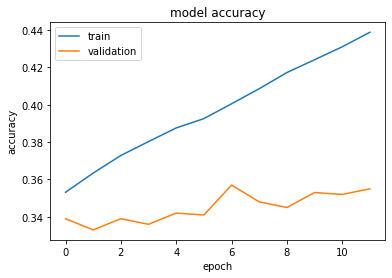

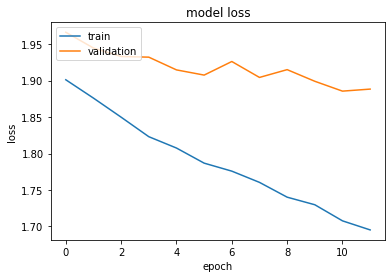

<Figure size 432x288 with 0 Axes>

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('evaluation.png', format='png', dpi=1200)

In [ ]:
from google.colab import files
files.download('evaluation.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
# predictions = [class_names[pred] for pred in predictions-1]

In [ ]:
predictions[1]

In [ ]:
accuracy_score(data_test.emotion, predictions)

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.emotion, predictions, average='micro') * 100))


Accuracy: 35.50%

F1 Score: 35.50


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 35.50


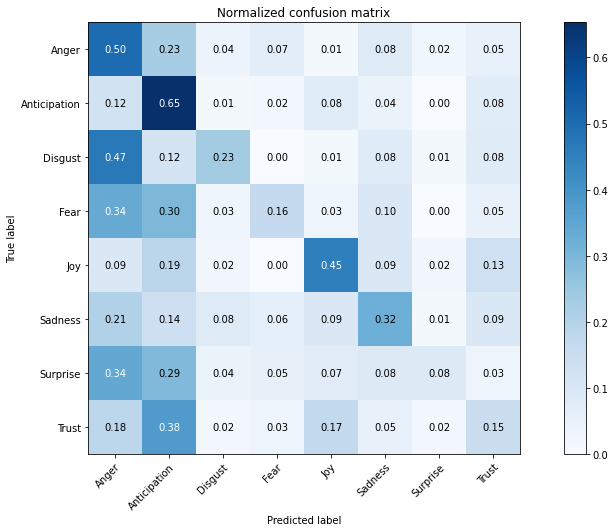

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
predictions1 = [class_names[pred] for pred in predictions-1]

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[9], predictions1[9]))

In [ ]:
X_test.head(10)